In [20]:
import pandas as pd
from matplotlib import pyplot as plt
import json
import csv

In [21]:
#kulutus ennuste
url_166 = "https://api.fingrid.fi/v1/variable/166/events/csv?start_time=2022-11-04T00%3A00%3A00Z&end_time=2022-11-05T00%3A00%3A00Z"
#tuulivoima tuotanto ennuste
url_245 = "https://api.fingrid.fi/v1/variable/245/events/csv?start_time=2022-11-04T00%3A00%3A00Z&end_time=2022-11-05T00%3A00%3A00Z"
#sähkötuotanto ennuste
url_241 = "https://api.fingrid.fi/v1/variable/241/events/csv?start_time=2022-11-04T00%3A00%3A00Z&end_time=2022-11-05T00%3A00%3A00Z"



def GetDataAPI(url):
    df = pd.read_csv(url)
    if url == "https://api.fingrid.fi/v1/variable/241/events/csv?start_time=2022-11-04T00%3A00%3A00Z&end_time=2022-11-05T00%3A00%3A00Z":
        df.to_csv("../Data/tuotanto_ennuste.csv")
    else:
        df.to_csv("../Data/kulutus_ennuste.csv")

GetDataAPI(url_166) # kulutusennuste
GetDataAPI(url_241) # tuotantoennuste

In [22]:
csvPathfile = r'/Users/oskaripuro/Desktop/Vscode/junction2022-1/Data/kulutus_ennuste.csv'
jsonpath = r"/Users/oskaripuro/Desktop/Vscode/junction2022-1/Data/data.json"

def make_json(csvPathfile, jsonFilePath):
     
    
    data = {}
     
    # Avaa
    with open(csvPathfile, newline="") as csvf:
        csvReader = csv.DictReader(csvf)
         
        # Jokainen rivi
        # ja lisää sen data
        for rows in csvReader:
             
            
            key = rows['']
            data[key] = rows
 
    # Open a json writer, and use the json.dumps()
    # function to dump data
    with open(jsonFilePath, 'w', encoding='utf-8') as jsonf:
        jsonf.write(json.dumps(data, indent=4))



make_json(csvPathfile, jsonpath)

In [23]:
df_kulutus = pd.read_csv("../Data/Kulutusennuste_Tammikuu_2021.csv")
df_tuotanto = pd.read_csv("../Data/Sahkontuotantoennuste_Tammikuu_2021.csv")

In [24]:
"""
Params:
interval = int
    how many data points to take account to find best rolling average

duration = int
    how many data points take count to calculating average

arr = [[start, end, value], [start, end, value],...]
    list of lists containing starting time ending time and value
"""
def ChargingTime(interval, duration, arr):
    # Käydään läpi ennustearvot ja lasketaan 'duration' pituinen liukuva keskiarvo
    # Keskiarvot taulukkoon jossa sarakkeet 'aloitusaika', 'lopetusaika' ja 'keskiarvo'
    # Keskiarvoista valitaan pienin
    # Return pienimmän keskiarvon aloitusaika
    print("Data on mitattu 5 min välein")
    print("interval on:", interval)
    print("eli tarkasteluväli on:", interval * 5, "minuuttia")

    print("duration on:", duration)
    print("eli latausaika on:", duration * 5, "minuuttia")
    avgs = []

        # Calculates averages
    for i in range(len(arr) - duration + 1):
        t1 = arr[i][0]
        t2 = arr[i][1]

        # Check if duration difference is bigger than interval
        if (pd.Timedelta(t2-t1).seconds / 60.0) > interval:
            break
        else:
            window = arr[i : i + duration]
            sum = 0
            for j in window:
                sum = sum + j[2]

            window_avg = round(sum / duration, 3)
                
            if (len(arr) - 1) > i + duration:
                avgs.append([arr[i][0], arr[i + duration][1], window_avg])

    # Find min average and select the starting duration to achieve that
    min_avg = [float('inf'), "", ""]
    for k in avgs:
        
        if min_avg[0] > k[2]:
            min_avg[0] = k[2]
            min_avg[1] = k[0]
            min_avg[2] = k[1]

    return min_avg

In [25]:
# Muutetaan arvot datetime:ksi
df_kulutus["Alkuaika UTC+02:00"] = pd.to_datetime(df_kulutus["Alkuaika UTC+02:00"])
df_kulutus["Lopetusaika UTC+02:00"] = pd.to_datetime(df_kulutus["Lopetusaika UTC+02:00"])

# Nimetään aikaväli
start_date = pd.to_datetime("2021-01-10 01:00:00")
end_date = pd.to_datetime("2021-01-20 23:00:00")

# Rajataan aikavälin mukaan
df_kulutus_filt = df_kulutus[(df_kulutus['Alkuaika UTC+02:00'] > start_date) & (df_kulutus['Lopetusaika UTC+02:00'] <= end_date)]

# Valitaan vain kolme saraketta
df_kulutus_filt = df_kulutus_filt[['Alkuaika UTC+02:00', 'Lopetusaika UTC+02:00', 'Kulutusennuste - seuraava vuorokausi']]
data = df_kulutus_filt.values.tolist()

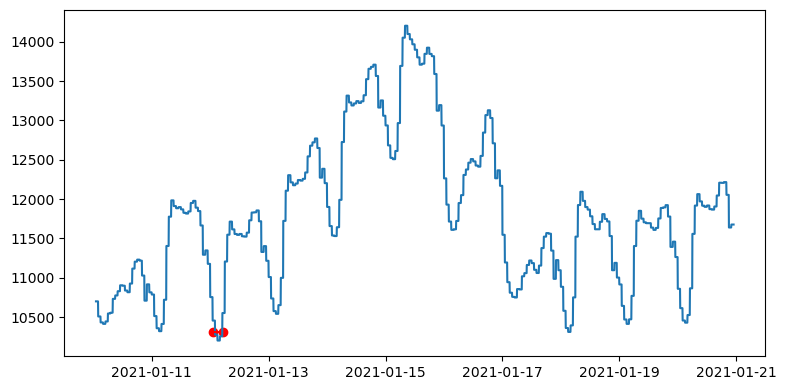

In [26]:
output = ChargingTime(720, 24, data)

plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.autolayout"] = True

plt.plot(df_kulutus_filt["Alkuaika UTC+02:00"], df_kulutus_filt["Kulutusennuste - seuraava vuorokausi"])
plt.scatter(output[1], output[0], c="red")
plt.scatter(output[2], output[0], c="red")

x_values = [output[1], output[2]]
y_values = [output[0], output[0]]

plt.plot(x_values, y_values, c="red", linestyle="--")
plt.show()